In [1]:
import os

if "jbook" in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../..")))
import warnings

warnings.filterwarnings("ignore")
FORCE = False

# AppVoCAI Dataset
The AppVOCAI Dataset consists of 22 million reviews spanning 14 categories, collected from the Apple App Store over a two-week period ending early September 2023. The data was sourced from publicly accessible sections of the App Store, ensuring compliance with ethical standards and transparency throughout the process.

For this analysis, we've extracted the reviews submitted since January of 2021, to focus on more emergent trends and user needs. Here, we provide a concrete sense of the filtered dataset, its structure and features, in advance of data quality analysis, cleaning, preparation, feature engineering and more detailed exploratory analyses.  

In [2]:
from discover.app.analyzer import Analyzer
from discover.container import DiscoverContainer
from discover.infra.config.flow import FlowConfigReader
from discover.flow.data_prep.ingest.stage import IngestStage
from discover.infra.utils.visual.print import Printer

In [3]:
container = DiscoverContainer()
container.init_resources()
container.wire(
    modules=[
        "discover.flow.data_prep.stage",
        "discover.app.base",
    ],
)

## Dataset Ingestion
The following code snippets will extract the data from the raw dataset, performing basic transformations, such as data types, removal of newlines, and encoding (if necessary), then load the dataset into a Review object for examination. First, we load the configuration for the ingest stage.

In [4]:
reader = FlowConfigReader()
config = reader.get_config("phases", namespace=False)
stage_config = config["dataprep"]["stages"]["ingest"]

Next, we build and run the ingestion pipeline. 

In [5]:
stage = IngestStage.build(stage_config=stage_config, force=FORCE)
asset_id = stage.run()



# ============================================================================== #
#                              Data Ingestion Stage                              #
# ============================================================================== #



                              Data Ingestion Stage                              
                           Stage Started | Tue, 29 Oct 2024 20:01:29
                         Stage Completed | Tue, 29 Oct 2024 20:01:29
                           Stage Runtime | 0.0 seconds
                           Cached Result | True


# ============================================================================ #



Finally, we obtain the review dataset from the repository and instantiate an Analyzer object.

In [6]:
# Instantiate the repository
repo = container.repo.dataset_repo()
# Load the dataset from the repository
df = repo.get(asset_id).content
# Instantiate the Review object for analysis.
analyzer = Analyzer()

## AppVoCAI Dataset Overview


In [7]:
analyzer.overview(df=df)



                           AppVoCAI Dataset Overview                            
                       Number of Reviews | 59,021
                       Number of Authors | 58,898
                          Number of Apps | 8,009
                    Number of Categories | 14
                                Features | 12
                    Date of First Review | 2021-01-01 00:11:35
                     Date of Last Review | 2023-09-03 01:25:32


The AppVoCAI captures over 22 million reviews from nearly 16 million users. These reviews span some 36,377 apps across 14 categories., providing a diverse range of insights into user experiences. The dataset contains 12 features and spans from July 10, 2008, the date the appstore launched, through early September of 2023.

### AppVoCAI Dataset Structural Analysis
The dataset contains 12 variables, offering both qualitative and quantitative views user opinion. 

- **id**: Unique identifier for each review.
- **app_id**: Unique identifier for the app being reviewed.
- **app_name**: Name of the mobile application being reviewed.
- **category_id**: Four-digit identifier representing the category or genre of the app.
- **category**: Category or genre name of the app.
- **author**: Name or identifier of the reviewer.
- **rating**: Numeric rating provided by the author for the app.
- **content**: Detailed content of the review provided by the author.
- **vote_sum**: Total sum of votes on the usefulness of the rating.
- **vote_count**: Number of votes on the usefulness of the rating.
- **review_length**: Number of words in review.
- **review_age**: Age of review relative to the last review in the dataset.
- **date**: Date when the review was written.

In [8]:
analyzer.info(df=df)

,Column,DataType,Complete,Null,Completeness,Unique,Duplicate,Uniqueness,Size (Bytes)
0,id,string[python],59021,0,1.0,59021,0,1.000000,3960250
1,app_id,string[python],59021,0,1.0,8009,51012,0.135697,3925843
2,app_name,string[python],59021,0,1.0,8005,51016,0.135630,4786582
3,category_id,category,59021,0,1.0,14,59007,0.000237,60431
4,author,string[python],59021,0,1.0,58898,123,0.997916,4544617
5,rating,int16,59021,0,1.0,5,59016,0.000085,118042
6,content,string[python],59021,0,1.0,55739,3282,0.944393,29067724
7,vote_sum,int64,59021,0,1.0,41,58980,0.000695,472168
8,vote_count,int64,59021,0,1.0,50,58971,0.000847,472168
9,date,datetime64[ms],59021,0,1.0,58970,51,0.999136,472168


Here's a summary of key insights based on the provided dataset overview:

1. **ID and Uniqueness**:
   - The `id` column is showing some duplication (93 items) which will require treatment during the data cleaning stage.

2. **App-Specific Details (`app_id`, `app_name`)**:
   - Both `app_id` and `app_name` are highly duplicated, with only about 5.6% uniqueness, which suggests a large number of reviews per app.

3. **Category Distribution**:
   - `category_id` and `category` are consistent, each with only 14 unique categories, suggesting clear category classifications across apps.

4. **Authors and Reviews**:
   - The `author` column has a uniqueness of 86%, indicating that about 14% of the reviewers have submitted multiple analyzer. This may be valuable for user behavior analysis over time.

5. **Rating Consistency**:
   - The `rating` column has only 5 unique values, confirming that ratings follow a predefined scale, typical of app store ratings.

6. **Vote Metrics (`vote_count`, `vote_sum`)**:
   - Both `vote_count` and `vote_sum` have low uniqueness (0.075% and 0.057%), suggesting that vote distributions are limited in range, possibly clustering around common values.
   
7. **Review Length**:
   - `review_length` has a moderate uniqueness of 0.18%, showing some diversity in review length.
   
8. **Data Completeness**:
   - All columns are 100% complete, with no missing values, ensuring the dataset’s integrity for analysis.

9. **Data Volume and Memory Considerations**:
   - The dataset weighs in at about 4.9 Gb of memory, which may require special consideration during data preprocessing and modeling stages.

Next, we will examine the distributions of ratings, votes, review lengths overall and by category.

### Rating Analysis

,count,mean,std,min,25%,50%,75%,max
rating,59021.0,3.660307,1.704811,1.0,2.0,5.0,5.0,5.0


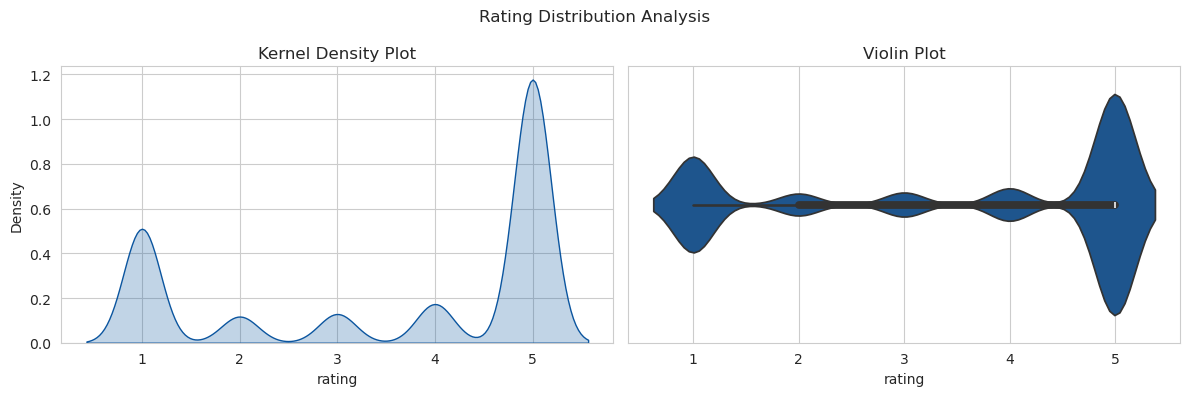

In [9]:
analyzer.distplot(df=df, x="rating", title="Rating Distribution Analysis")

The distribution of ratings across the dataset shows a noticeable skew toward higher ratings. While the minimum rating is 1, the majority of the reviews are concentrated around the higher end of the scale—half of the ratings are 5, as reflected in the 50th, 75th, and maximum percentiles, all being 5. This suggests that users are more likely to give positive ratings, though there is still a portion of the dataset with moderate to lower ratings, as indicated by the lower 25th percentile.

The KDE and violin plots further emphasize this trend, visually highlighting the density of high ratings and the thinner distribution in the lower range and a concentration of reviews toward the maximum rating.

### Review Length Analysis
Review length offers key insights into the potential depth and richness of app analyzer. **Longer reviews** often contain more detailed feedback, making them valuable for advanced sentiment and aspect-based analysis, while **shorter reviews** may offer limited but frequent surface-level sentiments. Understanding the distribution of review lengths helps identify patterns in user engagement and guides decisions on data processing—such as handling outliers or segmenting reviews for further analysis. By analyzing review length, we gain a clearer picture of the dataset’s complexity and can better tailor modeling approaches to extract meaningful insights.


,count,mean,std,min,25%,50%,75%,max
review_length,59021.0,32.187323,40.91023,1.0,8.0,20.0,42.0,1284.0


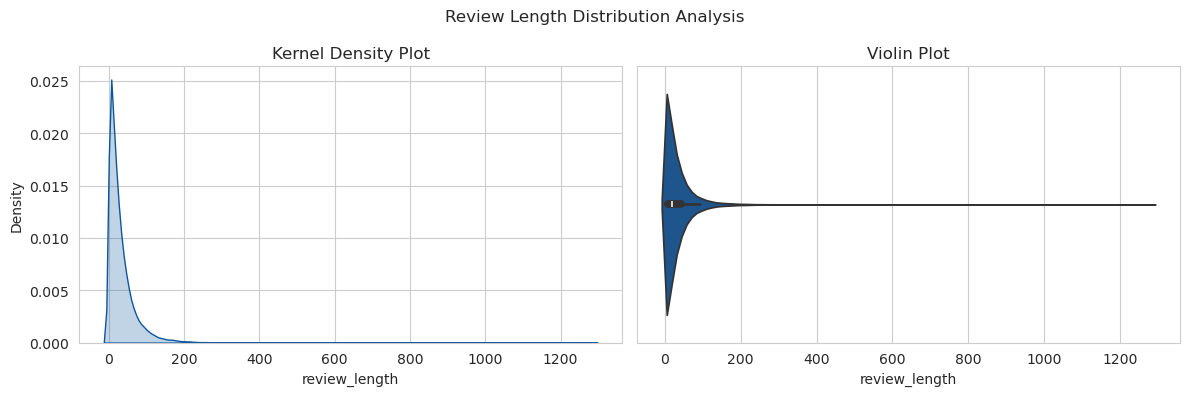

In [10]:
analyzer.distplot(df=df, x="review_length", title="Review Length Distribution Analysis")

Several observations are prominent:

- **Skewed Distribution**: The large difference between the mean (32.42 words) and the median (20 words) suggests a right-skewed distribution, with a small number of very long reviews pulling up the mean. The maximum review length of 2,624 words reinforces the presence of these outliers.
  
- **Prevalence of Short Reviews**: The 25th percentile of 8 words and the high concentration of reviews below the 42-word mark (75th percentile) indicate that a significant portion of reviews are very short, possibly affecting their informativeness. These short reviews may not provide detailed insights and could be less valuable for deeper sentiment or aspect analysis.
  
- **Variation in Review Length**: With a standard deviation of 41.03, there's substantial variability in review lengths. This variability means that different types of analyses, such as summarization or sentiment extraction, may need to account for review length, as longer reviews might contain more nuanced opinions or multiple aspects.

The accompanying histogram and violin plots show the concentration of shorter reviews and highlight the long tail of very lengthy reviews, illustrating the spread and density of review lengths.

### Vote Count and Vote Sum
The dataset includes two important metrics for evaluating the interaction with app reviews: **vote count** and **vote sum**.

- **Vote Count** reflects the total number of votes a review has received. This primarily measures engagement, indicating how many users interacted with the review. A high vote count shows that the review attracted attention, but it does not necessarily reflect the quality or usefulness of the review.

- **Vote Sum** aggregates the net value of all votes, providing a clearer indication of the review’s **informativeness**. A higher vote sum suggests that users found the review helpful or insightful, making it a stronger indicator of the review's contribution to understanding the app’s performance or issues. However, while a high vote sum may imply some level of agreement with the review, this cannot be assumed. Further **sentiment analysis** would be required to determine whether users generally agree with the sentiments expressed in the review.

In this context, **vote sum** serves as a valuable metric for identifying reviews that provide meaningful or detailed insights, while **vote count** highlights the level of engagement or visibility.

#### Vote Count Analysis

,count,mean,std,min,25%,50%,75%,max
vote_count,59021.0,0.257925,24.422045,0.0,0.0,0.0,0.0,5052.0


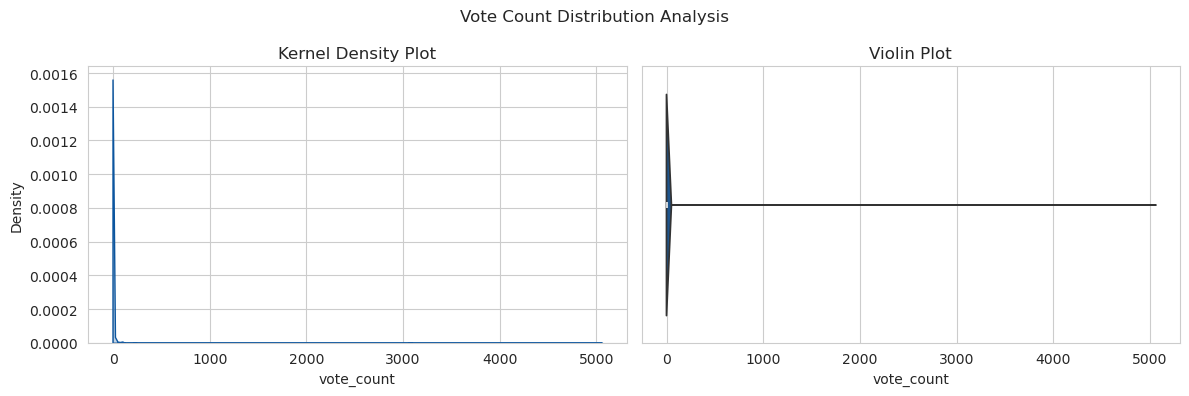

In [11]:
analyzer.distplot(df=df, x="vote_count", title="Vote Count Distribution Analysis")

The statistics for **vote count** offer some key insights into how reviews are interacted with by users:

- **Heavily Skewed Distribution**: With a median of 0 and a 75th percentile also at 0, the majority of reviews receive no votes at all. This highlights that only a small fraction of reviews are being engaged with by the community. The fact that the mean is 0.155, significantly inflated by the few reviews with a large number of votes, further emphasizes the skewed nature of the distribution.

- **High Variability**: The standard deviation of 5.93, combined with a maximum vote count of 5,928, indicates that while most reviews receive little to no interaction, a few outliers receive significant attention. These outliers likely represent highly influential or visible reviews that may play a critical role in shaping user opinions.

Let's take a look at the top 10 vote count distribution.

In [12]:
analyzer.freqdist(df=df, x="vote_count", topn=10)

,count,%
vote_count,,
0,55578,94.17
1,2686,4.55
2,409,0.69
3,135,0.23
4,56,0.09
5,34,0.06
6,21,0.04
7,15,0.03
8,11,0.02


These additional statistics for **vote count** reinforce the earlier observation of a highly skewed distribution, providing even more clarity on the nature of engagement:

- **Overwhelming Majority of Reviews Receive No Votes**: With 94.10% of reviews having 0 votes, it’s clear that most reviews are not engaged with at all. This suggests that user engagement is concentrated on a small subset of reviews, making it important to carefully examine the minority of reviews that do receive votes for their potential influence.

- **Sharp Drop-off After 1 Vote**: Only 4.52% of reviews receive 1 vote, and the percentage of reviews receiving 2 or more votes rapidly diminishes. This suggests that even a single vote marks a review as somewhat exceptional in terms of visibility or user engagement.

- **Long Tail of Rarely Voted Reviews**: The small percentages for reviews receiving 2 or more votes illustrate the presence of a long tail, with very few reviews accumulating significant votes. This is consistent with the earlier finding of a few highly voted outliers driving the mean up, despite the majority receiving no interaction.

- **Implications for Analysis**: Overall, these percentages highlight the fact that engagement is sparse and highly concentrated, which may affect the way vote counts are used as a signal in analysis. Given that a vast majority of reviews have no votes, the vote count metric alone may not be useful in distinguishing most analyzer. Rather, the reviews that do receive votes, especially those with more than 1 or 2 votes, indicate greater visibility, and possibly influence or importance. 

Another, perhaps better indicator of influence is vote sum.

#### Vote Sum Analysis

,count,mean,std,min,25%,50%,75%,max
vote_sum,59021.0,0.163061,13.389055,0.0,0.0,0.0,0.0,2749.0


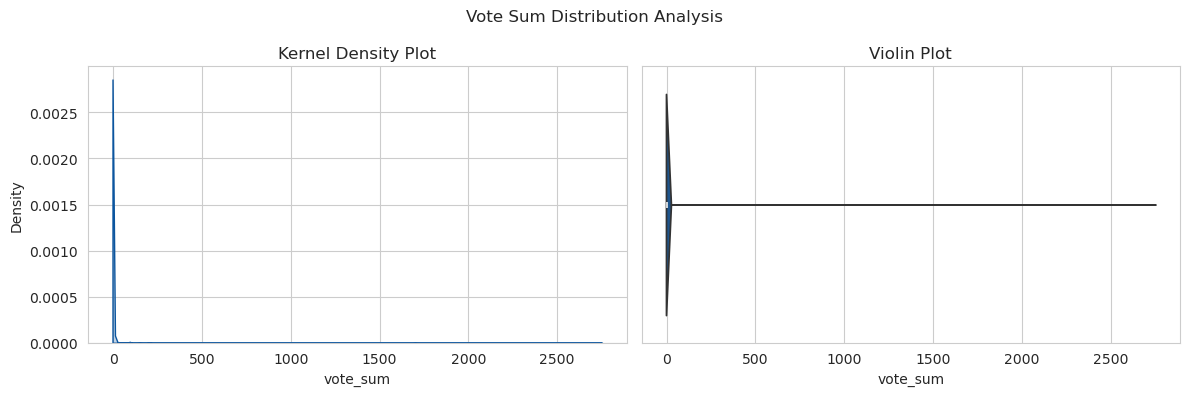

In [13]:
analyzer.distplot(df=df, x="vote_sum", title="Vote Sum Distribution Analysis")

In [15]:
analyzer.freqdist(df=df, x="vote_sum", topn=10)

,count,%
vote_sum,,
0,56378,95.52
1,2118,3.59
2,287,0.49
3,96,0.16
4,37,0.06
5,27,0.05
6,15,0.03
7,10,0.02
9,5,0.01


The **vote sum** statistics and distribution provide further insight into the overall interaction with app reviews:

##### Vote Sum Statistics:
- **Sparse Engagement**: With a mean of 0.10436 and a standard deviation of 3.55, the vast majority of reviews have little to no cumulative voting activity. The skewed nature of the distribution is again evident, with the 25th, 50th (median), and 75th percentiles all at 0, showing that most reviews receive no meaningful voting interaction.
  
- **High Variability**: The maximum vote sum of 2,804 illustrates that a small subset of reviews receives significant positive feedback, suggesting that these reviews are particularly informative or impactful. However, such high vote sums are extremely rare.

##### Vote Sum Distribution:
- **96.17% of Reviews Have No Vote Sum**: The vast majority of reviews do not receive any vote sum, reinforcing the earlier observation that user engagement is concentrated on a very small subset of analyzer. This high percentage of zero vote sums indicates that only a small portion of reviews is seen as helpful or relevant by the community.

- **A Small Fraction of Reviews Stand Out**: Only 3.61% of reviews receive a vote sum of 1, with progressively fewer reviews receiving higher vote sums. The rapid decline in percentage for higher vote sums shows that informative reviews (as inferred by their vote sum) are exceedingly rare. 

- **Implications**: Since vote sum reflects perceived informativeness, the small number of reviews with a non-zero vote sum suggests that only a handful of reviews are considered highly useful by readers. For analysis, this could mean that reviews with high vote sums might be prioritized for deeper insight extraction, while the overwhelming majority of reviews with no votes may be of lower priority or less informative.

This sparse engagement, combined with the presence of outliers, suggests that **vote sum** is a valuable but rare indicator of review quality and potential influence.

### Review Date Analysis
The review date analysis focuses on understanding temporal trends in user feedback. It examines when reviews were submitted to uncover patterns, peaks in user engagement, and potential seasonal trends over time.

,count,mean,min,25%,50%,75%,max
date,59021,2022-05-14 12:24:51.990000,2021-01-01 00:11:35,2021-09-07 04:50:08,2022-05-24 19:53:06,2023-01-26 13:21:32,2023-09-03 01:25:32


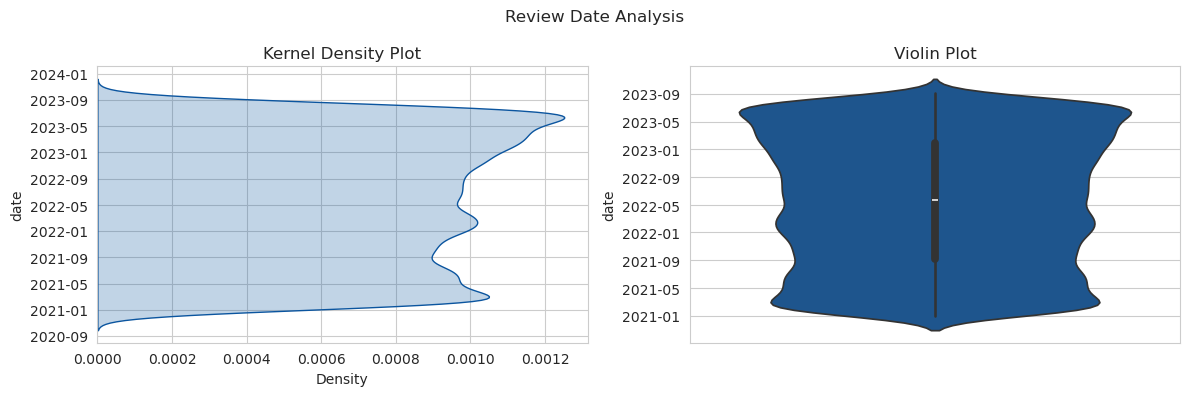

In [17]:
analyzer.distplot(df=df, y="date", title="Review Date Analysis")

The **review date** statistics provide insights into the temporal distribution of app reviews:

1. **Time Span**: The reviews cover a period from **January 1, 2021, to September 3, 2023**—spanning nearly three years. This period is recent enough to capture the current landscape while also offering insight into year-over-year changes.

2. **Concentration**: The data shows a slight concentration around **2022**, with both the median and mean review dates falling in mid-2022. This suggests an increase in reviews during that time, possibly reflecting app updates, feature releases, or shifts in user engagement during this period.

3. **Recency**: The 75th percentile date is **January 25, 2023**, indicating that 25% of reviews were added since 2023. The latest data point is **September 2023**, meaning the dataset is fairly up-to-date, although missing 2024 data. 

These trends suggest that the majority of the dataset's insights will come from the most recent years, where review activity is highest.

### App Review Frequency Analysis

,count,mean,std,min,25%,50%,75%,max
app_name,8005.0,7.373017,53.206199,1.0,1.0,2.0,4.0,3870.0


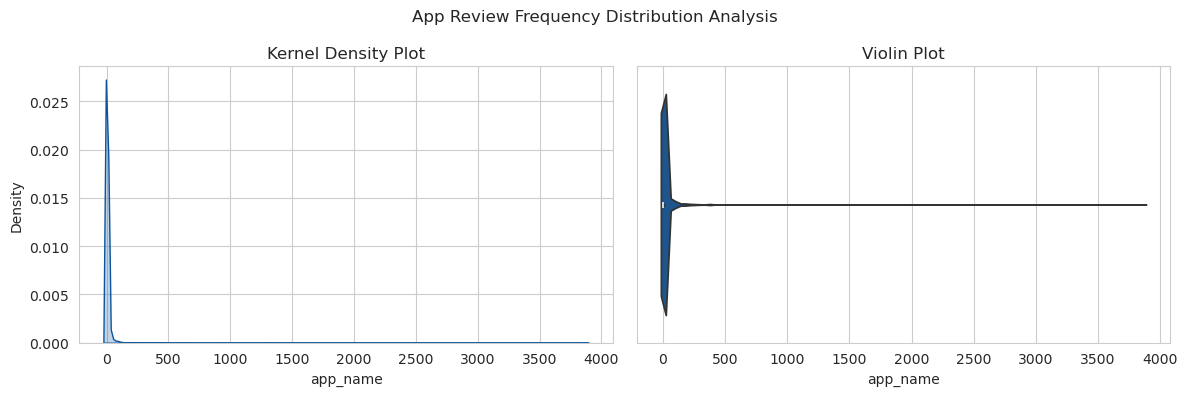

In [18]:
analyzer.freqdistplot(
    df=df, x="app_name", title="App Review Frequency Distribution Analysis"
)

Let's examine the most reviewed apps.

,count,mean,std,min,25%,50%,75%,max
count,8005.0,7.373017,53.206199,1.0,1.0,2.0,4.0,3870.0


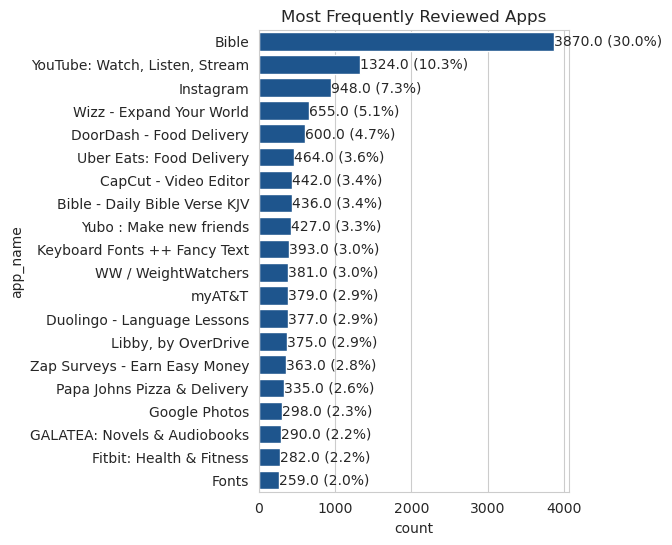

In [19]:
analyzer.freqplot(df=df, y="app_name", topn=20, title="Most Frequently Reviewed Apps")

The **app review frequency** statistics provide insights into the distribution of reviews across different apps:

- **Highly Skewed Distribution**: The mean of 178 reviews per app is heavily skewed by a small number of apps with extremely high review counts, as indicated by the large standard deviation (2,612 reviews) and a maximum of 381,236 analyzer. This suggests that while a few apps receive a vast number of reviews, the majority have far fewer.

- **Highly Popular Apps**: The 75th percentile (41 reviews) shows that only a quarter of the apps receive over 40 analyzer. The chart clearly shows that a small number of apps dominate the review space. YouTube and Bible, with 351,236 and 138,251 reviews respectively, alone account for over 30% of all reviews in the dataset. These apps, along with a few others like MyFitnessPal, Messenger, and Instagram, capture a large portion of user engagement, further emphasizing the skewed distribution of analyzer.

- **Most Apps Have Few Reviews**: The 25th percentile is 4 reviews, and the median is just 11, meaning that half of the apps have fewer than 12 analyzer. This implies that many apps in the dataset receive relatively low engagement, while a small subset dominates the review count.
  
- **Significant Engagement Drop-off**: After the top five apps, the number of reviews per app drops significantly, although the apps in the mid-tier, such as DoorDash, Uper Eats, and Instagram, still have review counts ranging from around 52,000 to 95,000. These apps, while popular, don't reach the same scale of review activity as the top few.

- **Long Tail of Reviews**: Despite the presence of some apps with hundreds of thousands of reviews, there’s a steep drop-off in review counts as you move further down the list, indicating that the vast majority of apps have far fewer reviews, aligning with the earlier statistical findings.

- **Distribution Insights**: The visualization makes it clear that just a small fraction of apps dominate user attention and feedback, while a large number of apps are relatively underrepresented in terms of review volume. This confirms that any analysis of user feedback must account for the dominance of a few apps to avoid skewing insights based on the behavior of a minority of apps.

These statistics highlight the unequal distribution of reviews across apps, with a few very popular apps skewing the overall average, while most apps remain relatively under-reviewed. This distribution suggests that analyses of highly reviewed apps may yield different insights than those focused on less reviewed apps, and both groups may need to be treated separately to avoid overrepresentation of popular apps in general trends.

### Review Author Frequency Analysis
The analysis of review author stats sheds light on user engagement patterns and the diversity of perspectives in the dataset. 

,count,mean,std,min,25%,50%,75%,max
author,58898.0,1.002088,0.046389,1.0,1.0,1.0,1.0,3.0


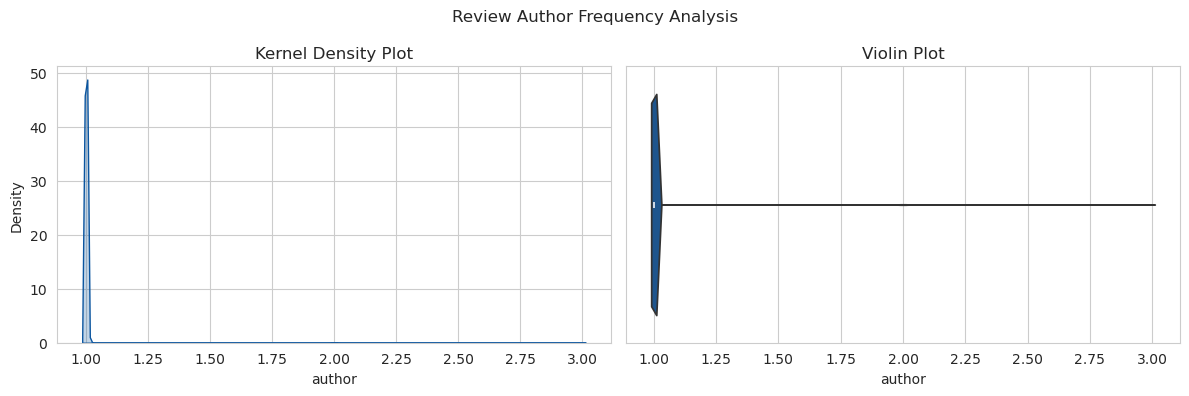

In [20]:
analyzer.freqdistplot(df=df, x="author", title="Review Author Frequency Analysis")

The **review author statistics** show that contributions are dominated by single-review authors, with a small group of frequent contributors influencing the mean and variance. Here’s a refined summary:

1. **Predominantly Single Contributions**:
   - The 25th, 50th (median), and 75th percentiles are all **1**, indicating that the vast majority of authors contribute only **one review**. This reflects common user behavior, where most users provide feedback infrequently and only on specific apps.

2. **Low Mean with Limited Variability**:
   - The mean of **1.16 reviews per author** is slightly above one, reflecting a small but notable group of users contributing multiple analyzer. However, with a standard deviation of **0.6**, variation in author activity is limited, with most authors contributing close to one review.

3. **Outliers**:
   - The maximum of **86 reviews** by a single author represents a distinct outlier and highlights a few highly active users who engage frequently. These power users may influence the overall dataset, especially in areas requiring deeper engagement or consistent feedback.

4. **Implications for Analysis**:
   - Since most authors provide only one review, analysis focused on individual contributions will capture typical user feedback, while tracking frequent contributors might reveal valuable insights across multiple apps. This distribution highlights a long-tail effect, where a few prolific reviewers stand out against the many single-review authors.

### Category Analysis

#### Reviews by Category Analysis

,count,mean,std,min,25%,50%,75%,max
count,14.0,4215.785714,2555.039189,180.0,2364.25,4168.0,5147.75,9432.0


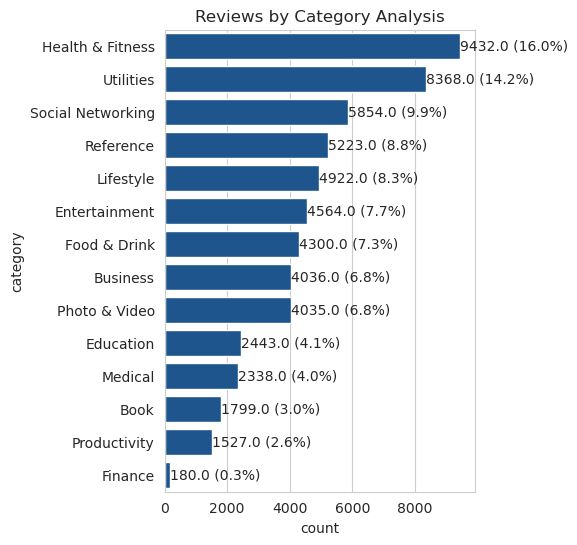

In [21]:
analyzer.freqplot(df=df, y="category", title="Reviews by Category Analysis")

The **Review Count by Category** analysis offers a nuanced view of user engagement across different app categories:

1. **Skewed Distribution**:
   - Review counts are highly skewed, with certain categories receiving vastly more reviews than others. Categories like **Health & Fitness** and **Utilities** have a large share of reviews, while **Finance** stands out as an outlier with significantly fewer analyzer.

2. **Top Categories**:
   - The highest-reviewed categories, such as **Health & Fitness**, **Utilities**, and **Social Networking**, account for a substantial portion of overall analyzer. These likely include apps with broad appeal, drawing consistent engagement.

3. **Moderate and Low-Volume Categories**:
   - Categories like **Business**, **Education**, **Reference**, and **Productivity** have moderate review counts, suggesting stable but more niche engagement.
   - **Finance** is a unique low-volume category, with just under 40,000 reviews, possibly due to the utilitarian nature of finance apps, which may see less frequent user feedback.

4. **Summary Statistics**:
   - The mean review count is **421,575**, but with a high standard deviation (256,054), indicating significant variability.
   - The median (418,121) and 75th percentile (510,229) confirm that only a few categories dominate, while others have fewer interactions.

5. **Implications for Analysis**:
   - This skewed distribution suggests that high-volume categories will likely drive overarching trends. For a balanced analysis, it may be useful to separate insights by review volume, ensuring that high-engagement categories don’t overshadow more niche ones, such as **Finance** or **Medical**. 

Overall, the variability across categories underscores differences in engagement levels, likely influenced by the specific functions and appeal of each app category.

#### Category Rating Analysis

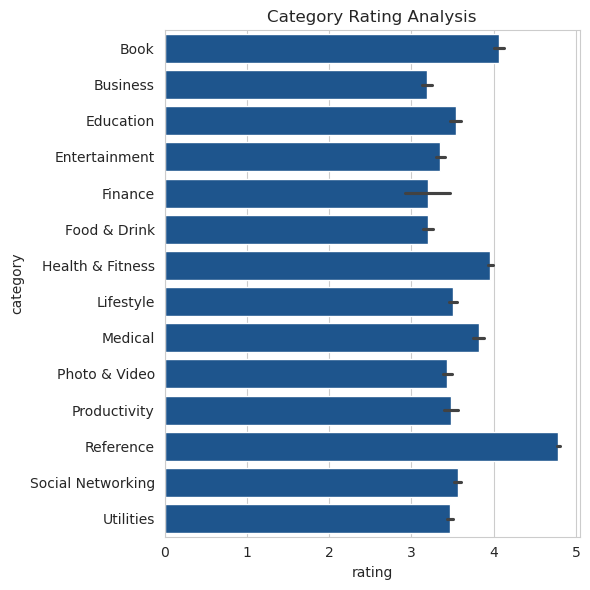

In [22]:
analyzer.assocplot(df=df, x="rating", y="category", title="Category Rating Analysis")

Yes, I can see the chart you shared! Here’s a summary of insights based on the **Category Rating Analysis**:

1. **High-Rated Categories**:
   - **Book** and **Reference** categories have the highest average ratings. This might indicate that apps in these categories consistently meet or exceed user expectations, possibly due to their straightforward functionality (e.g., reference materials or reading).

2. **Lower-Rated Categories**:
   - **Finance**, **Business**, and **Utilities** have comparatively lower average ratings, which could suggest user dissatisfaction with aspects such as complexity, reliability, or usability. For instance, financial apps might face high user expectations and receive lower ratings if issues arise.

3. **Relatively Uniform Ratings**:
   - Categories like **Education**, **Entertainment**, **Health & Fitness**, and **Productivity** have more uniform ratings, showing stable but slightly lower user satisfaction than top-rated categories.

4. **Narrow Rating Ranges**:
   - Categories such as **Medical**, **Lifestyle**, and **Social Networking** show narrower rating distributions, indicating that user experiences within these categories may be more consistent, either positively or negatively.

5. **Contextual Factors**:
   - The variance in ratings by category suggests that app purpose affects user expectations. For example, critical-function apps (like Finance or Medical) might receive harsher ratings due to higher expectations, whereas leisure-oriented categories (like Book and Entertainment) tend to receive more favorable ratings.

The chart reveals that ratings differ significantly by category, with some (like Book and Reference) performing well, while others (like Finance and Business) face more challenges in meeting user expectations. This provides valuable context for understanding user satisfaction across app types.

#### Category Review Length Analysis

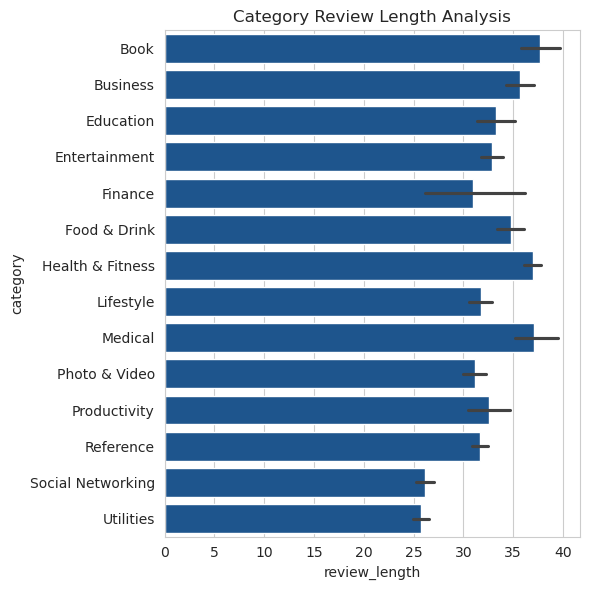

In [23]:
analyzer.assocplot(
    df=df, x="review_length", y="category", title="Category Review Length Analysis"
)

Here’s an updated analysis of the **Category Review Length Analysis** chart based on the provided image:

1. **Longer Reviews in Certain Categories**:
   - Categories like **Health & Fitness**, **Reference**, and **Productivity** have slightly longer average review lengths, indicating that users in these areas tend to leave more detailed feedback. This may be due to the functional or critical nature of these apps, where users feel the need to share detailed experiences or provide specific feedback related to usability and functionality.

2. **Moderate to Consistent Review Lengths Across Most Categories**:
   - Many categories, including **Education**, **Entertainment**, **Medical**, and **Photo & Video**, show review lengths that are relatively consistent and moderate. These categories generally stay within a similar range, suggesting that users provide moderate levels of detail in their feedback.

3. **Shorter Reviews in Other Categories**:
   - **Social Networking** and **Utilities** have shorter average review lengths. This could indicate that users leave more concise feedback in these categories, possibly because these apps are more familiar and don’t require extensive explanation.

4. **Finance and Business**:
   - Similar to the previous observation, **Finance** and **Business** show moderate review lengths, where users might be motivated to share specific issues or experiences but keep their feedback relatively concise. This could reflect a balance between the complexity of these apps and the tendency of users to give focused feedback on usability or reliability.

5. **Insights for Analysis**:
   - Longer reviews in categories like Health & Fitness and Productivity might provide richer insights, as they could contain multiple aspects, detailed complaints, or suggestions. Shorter reviews, while less detailed, might still reveal high-level sentiment trends, especially in categories with simpler or more familiar apps.

Review length generally aligns with the complexity or importance of the app category, with Health & Fitness, Reference, and Productivity attracting slightly longer reviews, while more casual categories like Social Networking and Utilities attract shorter, to-the-point feedback. This consistency provides a foundation for targeted analysis, as longer reviews may hold richer insights for in-depth analysis.

#### Category Vote Count Analysis

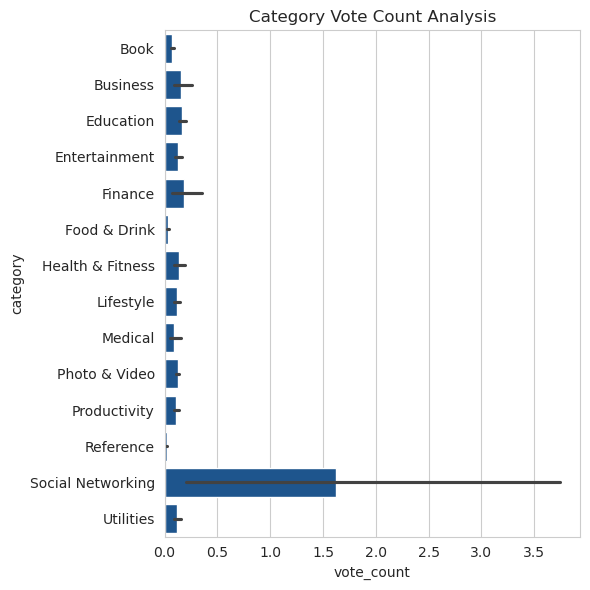

In [25]:
analyzer.assocplot(
    df=df, x="vote_count", y="category", title="Category Vote Count Analysis"
)

Several points are notable:

1. **High Engagement in Social Networking**:
   - The **Social Networking** category has the highest average vote count, suggesting strong user engagement with reviews in this category. This may reflect the social nature of these apps, where users rely more on feedback from others to guide their choices or confirm app quality.

2. **Moderate Engagement Across Other Categories**:
   - Categories such as **Education**, **Entertainment**, and **Productivity** show moderate vote counts, indicating that users engage fairly actively with reviews in these areas. These categories often have apps that people use frequently, leading to consistent interaction with reviews to help inform decisions.

3. **Lower Engagement in Categories like Food & Drink and Medical**:
   - Categories such as **Food & Drink** and **Medical** have relatively lower vote counts, suggesting that users engage less with reviews in these areas. This might indicate that users feel less need to validate reviews, possibly due to more personal or situational preferences for these apps.

4. **Broadly Consistent Vote Counts Across Most Categories**:
   - Despite some differences, most categories fall within a similar range, suggesting that user engagement with reviews doesn’t vary drastically. This points to an overall steady interaction level across categories, although some (like Social Networking) clearly stand out.

The chart shows that categories like **Social Networking** see high review engagement, likely due to the inherently social aspect of these apps. Meanwhile, **Food & Drink** and **Medical** apps tend to receive lower engagement on reviews, perhaps reflecting a more personal or straightforward user experience where fewer people feel compelled to interact with feedback.

#### Category Vote Sum Analysis

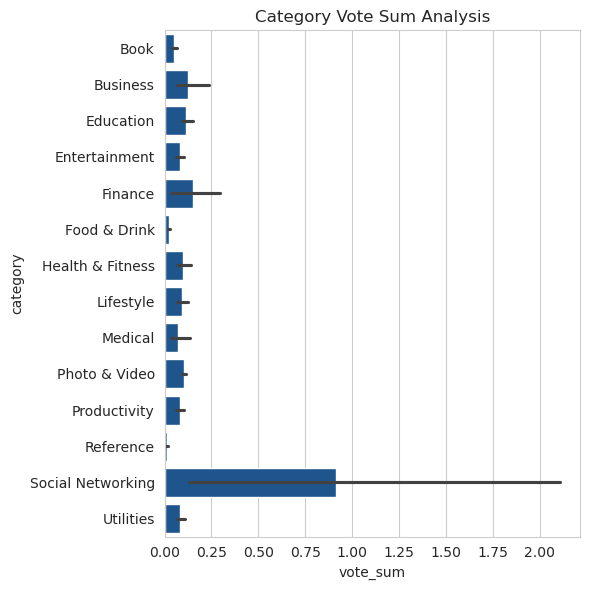

In [26]:
analyzer.assocplot(
    df=df, x="vote_sum", y="category", title="Category Vote Sum Analysis"
)

The `vote-sum` analysis reinforces that from `vpte_count`:

- **Productivity Leads Again**: Similar to vote count, the **Productivity** category also has the highest vote sum. This reinforces the idea that reviews in this category are seen as particularly informative or helpful, attracting positive feedback from users. Users may rely heavily on reviews to assess the effectiveness and functionality of productivity apps.

- **Business, Education, and Social Networking Show Strong Vote Sums**: These categories also rank relatively high in vote sum, suggesting that reviews in these areas are both engaged with and considered valuable. This likely reflects the importance of these apps in users' daily activities and the need for detailed feedback.

- **Lower Vote Sum in Food & Drink and Photo & Video**: These categories, similar to their lower vote count, also have lower vote sums, suggesting that reviews in these areas are not considered as informative or critical. Users may engage less with reviews in these categories or feel less inclined to rate them as helpful.

In summary:
- **Productivity Apps Stand Out**: Across both vote count and vote sum, **Productivity** apps clearly dominate, with users actively engaging with and valuing reviews in this category. This suggests that users place high importance on the quality and effectiveness of productivity tools, leading to more detailed and impactful analyzer.
  
- **Moderate to Low Engagement in Casual Categories**: Categories like **Photo & Video** and **Food & Drink** have lower vote counts and sums, indicating that users may engage with these apps more casually, leading to fewer and less impactful analyzer. 

This analysis shows that engagement with reviews varies significantly by category, with **Productivity** leading in both vote count and sum, while more casual app categories like **Food & Drink** and **Photo & Video** see lower engagement.

### AppVoCAI Dataset: Random Sample
This section presents a random sample of five reviews in table format, followed by a detailed analysis of each. We'll examine both qualitative aspects, like sentiment and key topics, and quantitative data, such as rating and vote count. By analyzing these reviews, we aim to obtain an indication of the types of insights we might uncover in the broader dataset.

In [28]:
samples = df.sample(n=5, random_state=27)
samples

,id,app_id,app_name,category_id,author,rating,content,vote_sum,vote_count,date,review_length,category
5278,10073145009,336377331,UPS Mobile,6000,8ec4613f6ea3f83e0e0e,5,I have the latest iOS on my iPhone 13 and late...,0,0,2023-06-26 04:13:00,40,Business
11602,9464679378,1075603018,Funimation,6016,f4ee2407043b0eb07d56,1,I sign up because they CLAIM that if you have ...,0,0,2023-01-03 02:53:07,34,Entertainment
30878,7875100285,1082828238,Cync (the new name of C by GE),6012,ef1bf390f6260cd2247d,5,Since the smart lights couldn’t function prope...,0,0,2021-10-04 01:44:02,125,Lifestyle
43275,8298043962,1242159382,Bulbapedia - Wiki for Pokémon,6006,b285ffa84b3a5b66bfb3,5,The app function so much better and looks much...,0,0,2022-01-30 02:43:36,10,Reference
14636,10266003751,867827909,SONIC Drive-In - Order Online,6023,ff0d15b9704cc868f316,5,"Saves me time & money, I love it!",0,0,2023-08-16 20:47:00,8,Food & Drink


The random sample of 5 observations include a mix of highly rated apps, as well as lower ratings, with a range of review lengths, all of which reflect different user experiences. However, a common feature across the sample is the absence of votes (both vote count and vote sum are zero), reinforcing either a low level of engagement with individual reviews or that votes are not a common interaction on these apps.

The reviews span a significant time range, from as early as 2011 to as recent as 2023, showcasing both historical and recent user sentiments. Review lengths vary from concise (7 words) to more detailed feedback (31 words), which highlights the difference in how users express their opinions depending on the app and personal style.

Overall, the sample reflects the broader patterns that may emerge in the dataset: varied user ratings, relatively short reviews, and minimal engagement in terms of votes. This suggests that future analysis may need to pay close attention to factors like review length, category-specific trends, and potential changes in engagement over time, especially for reviews that go unnoticed in terms of user votes.

#### Spectrum TV Review Analysis

In [29]:
printer = Printer()
printer.print_dataframe_as_dict(
    df=samples, list_index=0, title=samples["app_name"].values[0], text_col="content"
)



                                   UPS Mobile                                   
                                      id | 10073145009
                                  app_id | 336377331
                                app_name | UPS Mobile
                             category_id | 6000
                                  author | 8ec4613f6ea3f83e0e0e
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2023-06-26 04:13:00
                           review_length | 40
                                category | Business
I have the latest iOS on my iPhone 13 and latest UPS app. I was getting the same
white screen when opening the app. And as another person suggested, I deleted
and reinstalled the UPS and now it’s working fine.


This review provides insights into **qualitative** and **quantitative** aspects, highlighting user frustration with technical performance.

---

##### **Qualitative Analysis**:

- **Content and Context**:
  - The review describes two main issues:
    1. **Streaming Quality**: The user is dissatisfied with the app's performance, noting issues with video quality ("fuzzes out the pic") and buffering. They compare Spectrum TV unfavorably to other streaming apps, implying that their internet connection is not the problem, but rather the app itself.
    2. **Audio Compatibility**: The user reports a specific audio issue on Apple TV, where sound fails when switching to the Spectrum app, though it works fine on other apps.

- **Sentiment**:
  - The sentiment is negative, with a rating of 2 stars. The language reflects significant frustration, particularly with phrases like "terrible job" and "Do better spectrum."

- **Tone/Emotion**:
  - The tone conveys disappointment and frustration. Phrases like "Do better spectrum" emphasize the user's dissatisfaction and expectation for improvement.

- **Key Topics**:
  - Key topics include **streaming quality** (buffering and picture clarity) and **device compatibility** (sound issues on Apple TV). Both are critical technical aspects that impact user experience.

- **Clarity**:
  - The review is clear and detailed. At 81 words, it provides enough context to understand the user’s specific issues without ambiguity.

---

##### **Quantitative Analysis**:

- **Length**:
  - At 81 words, this review is moderately long, suggesting the user is invested enough to describe multiple issues rather than simply leaving a brief complaint.

- **Rating**:
  - The 2-star rating signals clear dissatisfaction, though it isn't the lowest rating, possibly indicating that the user sees potential in the app if improvements are made.

- **Vote Count/Engagement**:
  - The review has no votes (`vote_count = 0`, `vote_sum = 0`), which may suggest it hasn't gained visibility or that other users have not prioritized these issues.

- **Entropy/Complexity**:
  - The review includes specific technical details, which could contribute to moderate entropy. Words like "buffering," "streaming data," and "Apple TV" add to the complexity, likely making it more informative for developers seeking feedback on technical issues.

---

##### Summary:
This review highlights technical performance concerns with **Spectrum TV**, specifically around streaming quality and compatibility with Apple TV audio. The detailed feedback may reflect a user looking for constructive improvements rather than merely venting. The lack of engagement may indicate these issues are not widely experienced or that the review hasn't reached enough users. This type of review could be valuable for identifying recurring technical problems across similar analyzer. Further analysis of streaming-related complaints could reveal if these are common issues with Spectrum TV.

#### Instagram Review Analysis

In [30]:
printer.print_dataframe_as_dict(
    df=samples, list_index=1, title=samples["app_name"].values[1], text_col="content"
)



                                   Funimation                                   
                                      id | 9464679378
                                  app_id | 1075603018
                                app_name | Funimation
                             category_id | 6016
                                  author | f4ee2407043b0eb07d56
                                  rating | 1
                                vote_sum | 0
                              vote_count | 0
                                    date | 2023-01-03 02:53:07
                           review_length | 34
                                category | Entertainment
I sign up because they CLAIM that if you have the premium membership you can
have access to the english dubbed of One Piece. Well they LIED. Only like the
first season has dubbed.


This review of **Instagram** indicates some frustration:

---

##### **Qualitative Analysis**:

- **Content and Context**:
  - The user expresses dissatisfaction with the presence of **suggested posts and ads** in their feed, which appears to be overwhelming their personal content. This is a common concern among users who prefer an unfiltered experience on social media.
  - The strong reaction ("On the verge of deleting account") indicates the user may abandon the app if these issues persist, which points to a significant risk for user retention.

- **Sentiment**:
  - The sentiment is highly negative, as reflected by the 1-star rating and phrases like "SICK of it!!!" and "Would not recommend!!!!"

- **Tone/Emotion**:
  - The tone conveys frustration and annoyance, with the use of capital letters and multiple exclamation marks intensifying the sense of anger. This suggests a user who is close to leaving the app over these issues.

- **Key Topics**:
  - The main topics are **advertising** and **content curation**. The user is specifically unhappy with the prevalence of ads and suggested posts, which they perceive as intrusive to their Instagram experience.

- **Clarity**:
  - The review is clear and direct. Despite its brevity (26 words), it conveys strong feelings and specific grievances, making it easy to understand the user's complaints.

---

##### **Quantitative Analysis**:

- **Length**:
  - With only 26 words, this is a short review, likely indicating that the user was focused on expressing dissatisfaction without detailing the underlying issues or offering solutions.

- **Rating**:
  - The 1-star rating underscores extreme dissatisfaction, aligning with the content of the review, which is highly critical of Instagram’s ad-heavy content.

- **Vote Count/Engagement**:
  - This review has no votes (`vote_count = 0`, `vote_sum = 0`), which may indicate limited visibility or that others haven’t prioritized this complaint, even if they share similar frustrations.

- **Entropy/Complexity**:
  - Given the short length and use of strong emotional language, the review likely has low entropy (predictability), with common words reflecting a straightforward expression of frustration rather than a nuanced or complex opinion.

---

##### Summary:
This review highlights significant dissatisfaction with Instagram’s reliance on **ads and suggested posts**, which the user finds intrusive and overwhelming. The short, emotional tone suggests that the user is on the verge of abandoning the app, potentially signaling a retention risk for Instagram. Although this review hasn't gained engagement from other users, analyzing similar reviews could determine if this frustration is a widespread issue. Overall, this review points to key areas of user dissatisfaction, particularly for users seeking a more personalized and less commercialized experience on the platform.

#### Move! Coach Review Analysis

In [31]:
printer.print_dataframe_as_dict(
    df=samples, list_index=2, title=samples["app_name"].values[2], text_col="content"
)



                         Cync (the new name of C by GE)                         
                                      id | 7875100285
                                  app_id | 1082828238
                                app_name | Cync (the new name of C by GE)
                             category_id | 6012
                                  author | ef1bf390f6260cd2247d
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2021-10-04 01:44:02
                           review_length | 125
                                category | Lifestyle
Since the smart lights couldn’t function properly if I set them up with the
Google Home app, I had to resort to using Cync. Cync works a lot better,
although the lights do sometimes disconnect from the app, all you gotta do is
turn the lights off through it then close the app and reopen it again. Cync does
not permit the us

This review of **MOVE! Coach** focuses on the app’s usability and functionality.

---

##### **Qualitative Analysis**:

- **Content and Context**:
  - The user is frustrated with the app's **usability** and **lack of functionality**, specifically regarding the inability to log meals and exercises. They describe spending considerable time navigating the app's manuals, videos, and sections, only to find limited functionality (specifically, the option to add weight but not other health metrics).
  - This suggests a potential mismatch between user expectations and the app's features, as well as possible shortcomings in the app’s user interface and navigation.

- **Sentiment**:
  - The sentiment is clearly negative, with a 1-star rating and language that reflects frustration. Phrases like "Super frustrating" emphasize the user’s disappointment and dissatisfaction with the app's usability.

- **Tone/Emotion**:
  - The tone conveys frustration and disappointment, as the user feels let down by the app's lack of key features. This sentiment is intensified by the fact that the user put in considerable effort to understand the app's functionality.

- **Key Topics**:
  - Key topics include **feature accessibility** (finding features to log meals and exercises) and **usability** (difficulty navigating the app). These are critical areas in health and fitness apps where users expect ease of use and comprehensive functionality.

- **Clarity**:
  - The review is relatively clear, though there are some minor grammatical errors ("I doesn’t an hour"), likely stemming from user frustration or haste. However, the core message of dissatisfaction with the app's lack of functionality is conveyed effectively.

---

##### **Quantitative Analysis**:

- **Length**:
  - With 37 words, this review is brief but provides enough context to understand the user’s main issues, especially around app functionality.

- **Rating**:
  - The 1-star rating reinforces the user's strong dissatisfaction with the app. The rating aligns with the critical nature of the review content.

- **Vote Count/Engagement**:
  - This review has no votes (`vote_count = 0`, `vote_sum = 0`), which may indicate it hasn’t gained visibility or resonance with other users. However, the issues raised may still be relevant for product improvement.

- **Entropy/Complexity**:
  - The review likely has low entropy, as it uses common words and phrases to convey frustration. The straightforward language indicates immediate concerns without nuanced discussion.

---

##### Summary:
This review highlights significant usability issues with **MOVE! Coach**, focusing on the user's inability to find essential features such as meal and exercise logging. The frustration expressed reflects unmet expectations for a health and fitness app, where users anticipate easy access to comprehensive tracking features. The lack of engagement from other users may suggest that this experience is either unique to this user or not widely shared. However, if similar feedback is found in other reviews, it could indicate broader usability issues that may warrant improvement.

#### Pump Log App Review

In [32]:
printer.print_dataframe_as_dict(
    df=samples, list_index=3, title=samples["app_name"].values[3], text_col="content"
)



                         Bulbapedia - Wiki for Pokémon                          
                                      id | 8298043962
                                  app_id | 1242159382
                                app_name | Bulbapedia - Wiki for Pokémon
                             category_id | 6006
                                  author | b285ffa84b3a5b66bfb3
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2022-01-30 02:43:36
                           review_length | 10
                                category | Reference
The app function so much better and looks much nicer


This review of **Pump Log** provides insights into the app's effectiveness and emotional support for users, as well as value for cost.

---

##### **Qualitative Analysis**:

- **Content and Context**:
  - The review expresses strong satisfaction with the app’s role in supporting breastfeeding mothers. The user mentions that the app helped them persevere during challenging moments ("This app kept me going when I felt I couldn’t anymore"), indicating that the app provides not just functionality, but also emotional support and motivation.
  - The user also highlights the **value for cost**, noting that the extended options are "worth every bit" of the small charge. This speaks to the perceived value and effectiveness of the paid features.

- **Sentiment**:
  - The sentiment is highly positive, with a 5-star rating. The language used, such as "10/10 recommend" and "Worth every bit," conveys strong endorsement and satisfaction.

- **Tone/Emotion**:
  - The tone is enthusiastic and supportive. The user’s experience with the app is deeply personal, and they express gratitude, indicating that the app has had a meaningful impact on their breastfeeding journey.

- **Key Topics**:
  - Key topics include **recommendation** (highly recommending the app to other mothers) and **value for cost** (justifying the cost of extended options). The app’s supportive nature and functionality for "milk making mamas" are emphasized.

- **Clarity**:
  - The review is clear and concise. It provides specific praise for the app’s motivational support and value without any ambiguity.

---

##### **Quantitative Analysis**:

- **Length**:
  - At 33 words, the review is short but impactful, providing both a recommendation and specific reasons for the user’s satisfaction with the app.

- **Rating**:
  - The 5-star rating aligns with the review's positive tone and enthusiastic language, showing that the user finds the app exceptionally valuable.

- **Vote Count/Engagement**:
  - This review has no votes (`vote_count = 0`, `vote_sum = 0`), indicating that it hasn’t gained visibility or engagement from other users. However, its highly positive tone could resonate if promoted to a larger audience.

- **Entropy/Complexity**:
  - Given its brevity and straightforward language, the review likely has low entropy, using simple words to convey strong endorsement without much complexity.

---

##### Summary:
This review highlights the effectiveness of **Pump Log** in supporting breastfeeding mothers, both functionally and emotionally. The user’s enthusiastic recommendation and praise for the app’s value indicate a high level of satisfaction, particularly with the app’s role in motivating users during challenging times. Despite the lack of engagement, the review provides valuable insight into how this app meets specific user needs in a meaningful way. Analyzing similar reviews could reveal if this level of emotional impact is common among users of this app.

#### MyFitnessPal: Calorie Counter App Review

In [33]:
printer.print_dataframe_as_dict(
    df=samples, list_index=4, title=samples["app_name"].values[4], text_col="content"
)



                         SONIC Drive-In - Order Online                          
                                      id | 10266003751
                                  app_id | 867827909
                                app_name | SONIC Drive-In - Order Online
                             category_id | 6023
                                  author | ff0d15b9704cc868f316
                                  rating | 5
                                vote_sum | 0
                              vote_count | 0
                                    date | 2023-08-16 20:47:00
                           review_length | 8
                                category | Food & Drink
Saves me time & money,  I love it!


This review of **Pluto TV - Live TV and Movies** offers insights into user discovery and initial impressions of app content.

---

##### **Qualitative Analysis**:

- **Content and Context**:
  - The review reflects a positive initial discovery experience. The user recently found **Pluto TV** and is pleasantly surprised by the wide range of available TV shows, expressing appreciation for the app’s content library.
  - The user’s phrase, "I am amazed that you have so many," highlights satisfaction with the app’s offerings, suggesting that Pluto TV provides a breadth of content that appeals to new users.

- **Sentiment**:
  - The sentiment is very positive, as indicated by the 5-star rating and the words "amazed" and "thank you," which show the user's satisfaction and gratitude.

- **Tone/Emotion**:
  - The tone is enthusiastic and appreciative. The user's surprise at the content selection conveys excitement and a positive first impression.

- **Key Topics**:
  - Key topics include **content variety** (large selection of TV shows) and **user discovery** (newly finding the app). This feedback highlights the importance of content diversity in attracting and retaining new users for entertainment apps.

- **Clarity**:
  - The review is clear and concise. Although brief, it communicates both the user’s initial impression and appreciation effectively.

---

##### **Quantitative Analysis**:

- **Length**:
  - At 29 words, the review is short, focusing on the user’s initial excitement about discovering the app’s content without providing additional detail.

- **Rating**:
  - The 5-star rating aligns with the enthusiastic tone, showing that the user’s initial experience with the app was very positive.

- **Vote Count/Engagement**:
  - This review has no votes (`vote_count = 0`, `vote_sum = 0`), suggesting that it hasn’t gained visibility or engagement from other users. However, the positive tone could be influential if shared with prospective users.

- **Entropy/Complexity**:
  - The review likely has low entropy due to its straightforward language and short length, focusing on simple expressions of amazement and gratitude.

---

##### Summary:
This review reflects a highly positive initial experience with **Pluto TV**, focusing on the breadth of available content. The user's excitement at discovering the variety of TV shows highlights an important value proposition for the app in attracting new users. While the review lacks engagement from others, it underscores the impact of a diverse content library on first-time users. Further analysis of similar reviews could help identify if content variety is a recurring theme that appeals to new Pluto TV users.

## Dataset Summary and Key Insights
The dataset consists of 5.9 million observations, including approximately 5 million unique authors, 33,000 apps, and 14 categories, spanning from January 2021 to September 2023. It contains 12 features, providing a comprehensive overview of app reviews across multiple years and categories.

Our analysis included:
- **Structural Analysis**: We examined the dataset's structure, including data types, completeness, and uniqueness.
- **Distribution and Frequency Analyses**: Focused on ratings, review lengths, and vote patterns.
- **Random Sample Review Analysis**: We performed qualitative and quantitative analysis on randomly selected reviews to extract user sentiment and behavioral patterns.

### Key Observations:
1. **Duplicate IDs and Content**: Both duplicate review IDs and duplicate content will need to be addressed during data cleaning to ensure dataset integrity.
2. **Ratings Distribution**: The rating distribution is highly skewed towards higher ratings, with a majority of reviews rated on the upper end of the scale.
3. **Review Lengths**: Review lengths are right-skewed, with a small number of very long analyzer. Zero-length reviews should be removed as they provide no valuable information.
4. **Vote Count and Vote Sum**: These features are sparse, indicating that very few reviews receive engagement (votes), limiting their utility as indicators of review quality or influence.
5. **Review Timeline**: Reviews span from 2008 through 2023, with the highest concentration in 2020 and 2021, suggesting a spike in user feedback during this period.
6. **App Review Frequencies**: App review frequencies are also highly skewed, with a few apps receiving a disproportionately large number of reviews, indicating varying levels of user engagement across different apps.
7. **Author Behavior**: The vast majority of authors have written only one review, limiting the ability to track user behavior over time but offering insights into one-time interactions with apps.
8. **Category Insights**: Health & Fitness, Utilities, and Social Networking apps have garnered the highest number of reviews, indicating strong user engagement in these categories.

These findings provide a solid foundation for further analysis and highlight key areas for data cleaning and exploration.

Next, we conduct data cleaning to prepare the dataset for downstream modeling. 